# Tutorial: COSMO-1 analysis

Check if format and content are alright. Provide a short feedback to MeteoSwiss, so that we can then start the extraction for all files between 2016 - 2020.

In [1]:
# =======
# import packages

# for data
import xarray as xr
import xarray.ufuncs as xu
import numpy as np
#import pandas as pd

import logging
logger = logging.getLogger(__name__)
#logger.setLevel(logging.DEBUG)
logging.basicConfig(format='%(levelname)s: %(message)s', level=logging.INFO)
import warnings
warnings.filterwarnings('ignore')

# for plotting
try:
    import matplotlib.pyplot as plt
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature;
    %matplotlib inline
except:
    logger.warning("Matplotlib and/or Cartopy is not installed in your python environment. Xarray Dataset plotting functions will not work.")

In [2]:
# load ERA5 data
ds = xr.open_mfdataset('../data/COSMO-1/*.nc')
print(type(ds))
ds

<class 'xarray.core.dataset.Dataset'>


<xarray.Dataset>
Dimensions:         (time: 24, x_1: 429, y_1: 294)
Coordinates:
  * x_1             (x_1) float32 4.39e+05 4.4e+05 ... 8.66e+05 8.67e+05
  * y_1             (y_1) float32 4.05e+04 4.15e+04 ... 3.325e+05 3.335e+05
    lon_1           (y_1, x_1) float32 dask.array<chunksize=(294, 429), meta=np.ndarray>
    lat_1           (y_1, x_1) float32 dask.array<chunksize=(294, 429), meta=np.ndarray>
  * time            (time) datetime64[ns] 2017-08-04 ... 2017-08-04T23:00:00
Data variables:
    grid_mapping_1  (time) |S1 b'' b'' b'' b'' b'' b'' ... b'' b'' b'' b'' b''
    HSURF           (y_1, x_1) float32 dask.array<chunksize=(294, 429), meta=np.ndarray>
    SLO_ANG         (y_1, x_1) float32 dask.array<chunksize=(294, 429), meta=np.ndarray>
    SLO_ASP         (y_1, x_1) float32 dask.array<chunksize=(294, 429), meta=np.ndarray>
    U_10M           (time, y_1, x_1) float32 dask.array<chunksize=(1, 294, 429), meta=np.ndarray>
    V_10M           (time, y_1, x_1) float32 dask.array<chunksize=(1, 294, 429), meta=np.ndarray>
    VMAX_10M        (time, y_1, x_1) float32 dask.array<chunksize=(1, 294, 429), meta=np.ndarray>
    T_2M            (time, y_1, x_1) float32 dask.array<chunksize=(1, 294, 429), meta=np.ndarray>
    RELHUM_2M       (time, y_1, x_1) float32 dask.array<chunksize=(1, 294, 429), meta=np.ndarray>
    PS              (time, y_1, x_1) float32 dask.array<chunksize=(1, 294, 429), meta=np.ndarray>
    Z0              (time, y_1, x_1) float32 dask.array<chunksize=(1, 294, 429), meta=np.ndarray>
    TOT_PREC        (time, y_1, x_1) float32 dask.array<chunksize=(1, 294, 429), meta=np.ndarray>
Attributes:
    Conventions:     CF-1.6
    ConventionsURL:  http://cfconventions.org/cf-conventions/v1.6.0/cf-conven...
    institution:     MeteoSwiss (NMC Switzerland)
    source:          model: cosmo-1, production_status: unknown, version: 102...
    history:         Produced by fieldextra version v13.4.0 (v13.4.0) on 2021...

## Spatial and temporal resolution

In [3]:
for dim, name in zip(['x_1', "y_1", "time"], ["x", "y", "time"]):
    if dim == "time":
        delta = np.unique((
                    ds[dim].to_index()[1:] - 
                    ds[dim].to_index()[:-1])
                    .astype('timedelta64[h]')
            )
        print("Resolution in " + name + " is: ",np.mean(delta), "hours")
    else:
        delta = abs(np.unique((
                    ds[dim].values[1:] - 
                    ds[dim].values[:-1])
        ))
        print("Resolution in " + name + " is: ",np.mean(delta), ds[dim].attrs['units'])

Resolution in x is:  1000.0 m
Resolution in y is:  1000.0 m
Resolution in time is:  1.0 hours


In [4]:
print("Resolution in Lontitude (degrees) is: \n", np.unique(ds.lon_1.values[0][1:] - ds.lon_1.values[0][:-1]))
print("Resolution in Latitude (degrees) is: \n", np.unique(ds.lat_1.values[1:][0] - ds.lat_1.values[:-1][0]))

Resolution in Lontitude (degrees) is: 
 [0.01276875 0.0127697  0.01277065 0.01277161 0.01277256 0.01277351
 0.01277447 0.01277542 0.01277637 0.01277733 0.01277828 0.01277924
 0.01278019 0.01278114 0.0127821  0.01278305 0.012784   0.01278496
 0.01278543 0.01278591 0.01278639 0.01278687 0.01278734 0.01278782
 0.0127883  0.01278877 0.01278925 0.01278973 0.0127902  0.01279068
 0.01279116 0.01279163 0.01279211 0.01279259 0.01279306 0.01279354
 0.01279402 0.01279449 0.01279497]
Resolution in Latitude (degrees) is: 
 [0.00898361 0.00898743 0.00899124 0.00899506]


No regular grid found for dimension Longitude and Latitude. Not sure if this is a problem?

### Spatial extent

In [22]:
np.min(ds.lon_1.values)

5.275941

### Test coordinate transformation from Swiss to Lon Lat

In [23]:
from rasterio.warp import transform
ny, nx = len(ds['y_1']), len(ds['x_1'])
x, y = np.meshgrid(ds['x_1'], ds['y_1'])
# Rasterio works with 1D arrays
lon, lat = transform({'init': 'EPSG:21781'}, {'init': 'EPSG:4326'},
                     x.flatten(), y.flatten())
lon = np.asarray(lon).reshape((ny, nx))
lat = np.asarray(lat).reshape((ny, nx))

This lon and lat don't have the exact same values as lon_1 and lat_1 and are also irregular!

## Plotting

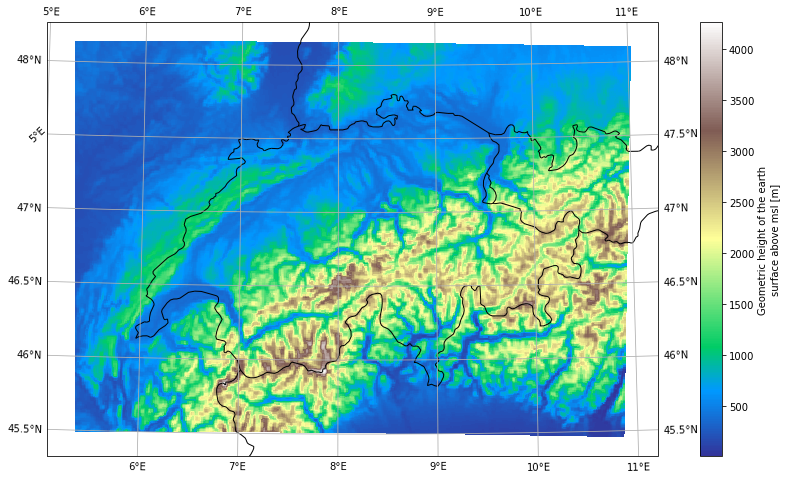

In [27]:
plt.figure(figsize=(15, 8))
ax = plt.axes(projection=ccrs.AlbersEqualArea(8.222665776, 46.800663464))
ds.HSURF.plot(ax=ax,x='lon_1', y='lat_1', cmap='terrain', transform=ccrs.PlateCarree())
ax.add_feature(cfeature.BORDERS, linestyle='-')
ax.gridlines(draw_labels=True)
plt.savefig('../docs/figures/topo_COSMO-1.png', dpi=200)

In [ ]:
plt.figure(figsize=(15, 8))

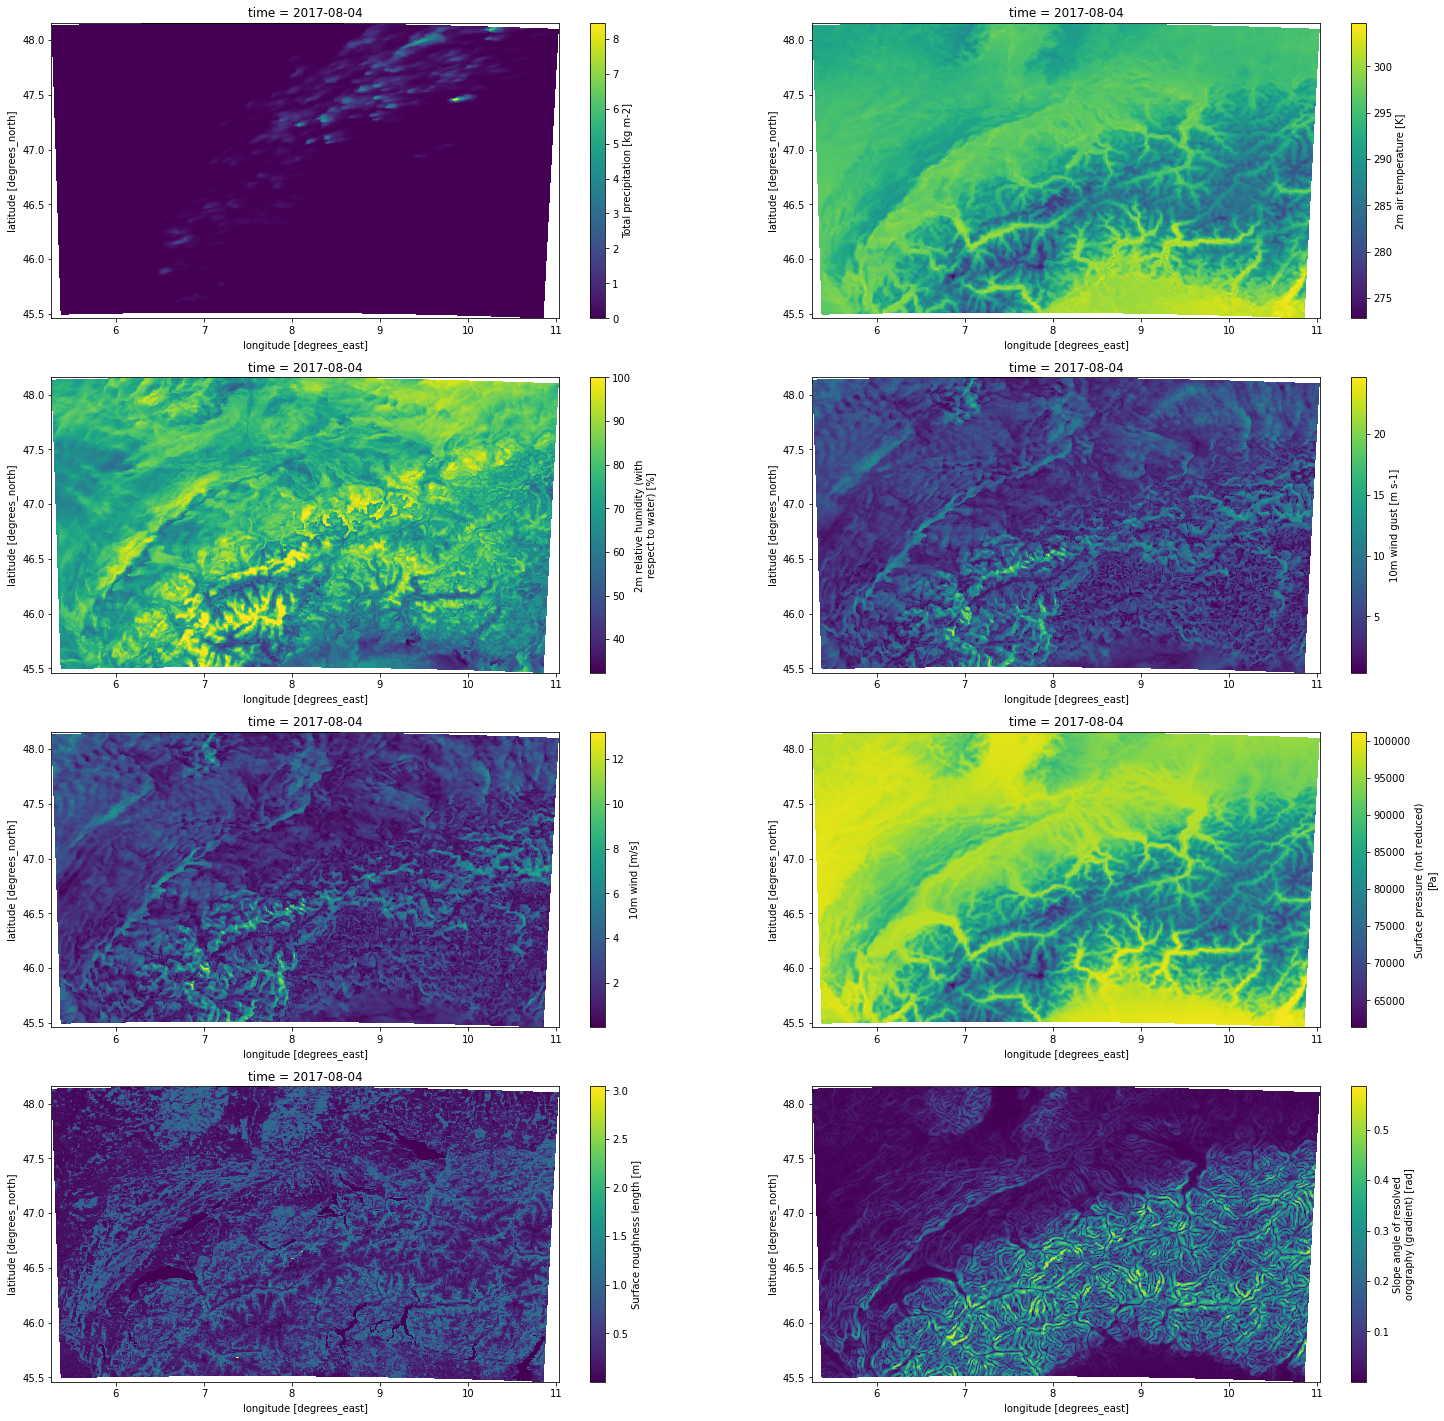

In [9]:
fig, axes = plt.subplots(4,2,figsize=(25, 25))

timestep = 0

ds.TOT_PREC.isel(time=timestep).plot(x="lon_1", y="lat_1", ax=axes[0,0])
ds.T_2M.isel(time=timestep).plot(ax=axes[0,1], x="lon_1", y="lat_1")
ds.RELHUM_2M.isel(time=timestep).plot(ax=axes[1,0], x="lon_1", y="lat_1")
ds.VMAX_10M.isel(time=timestep).plot(ax=axes[1,1], x="lon_1", y="lat_1")
fig5 = xu.sqrt(ds.U_10M**2+ds.V_10M**2).isel(time=timestep).plot(ax=axes[2,0], x="lon_1", y="lat_1"); fig5.colorbar.ax.set_ylabel('10m wind [m/s]')
ds.PS.isel(time=timestep).plot(ax=axes[2,1], x="lon_1", y="lat_1")
ds.Z0.isel(time=timestep).plot(ax=axes[3,0], x="lon_1", y="lat_1")
ds.SLO_ANG.plot(ax=axes[3,1], x="lon_1", y="lat_1")

In [30]:
# plot wind speed as animation: This nicely illustrates the spatial and temporal evolution of wind
from matplotlib import animation
from IPython.display import HTML, display
from matplotlib import rc
rc('animation', html='html5')

# calc wind speed (m/s) and store it as xarray data
windspeed = xu.sqrt(ds.U_10M**2+ds.V_10M**2).compute()

# Animation
fig, ax = plt.subplots(figsize=(15,8), subplot_kw=dict(projection=ccrs.AlbersEqualArea(8.222665776, 46.800663464)))
fig.subplots_adjust(left=0, bottom=0.01, right=1, top=1, wspace=None, hspace=None)
# Plot the initial frame. 
cax = windspeed[0,:,:].plot(
    ax = ax,
    transform=ccrs.PlateCarree(),
    x='lon_1', y='lat_1',
    add_colorbar=True,
    vmin=windspeed.values.min(), vmax=windspeed.values.max(),
    cbar_kwargs={
        'extend':'neither',
        'label':'wind speed [m/s]'
    }
)

# Next we need to create a function that updates the values, as well as the title.
def animate(frame):
    cax.set_array(windspeed[frame,:,:].values.flatten())
    ax.set_title("Time = " + str(windspeed.coords['time'].values[frame])[:13])
    ax.add_feature(cfeature.BORDERS, linestyle='-')

# Finally, we use the animation module to create the animation.
ani = animation.FuncAnimation(
    fig,            
    animate,         
    frames=24,      
    interval=200,
)

#writergif = animation.PillowWriter(fps=5) 
#ani.save('../docs/figures/wind_anim_COSMO1.gif', writer=writergif)

plt.close()

INFO: Animation.save using <class 'matplotlib.animation.PillowWriter'>


In [37]:
HTML(ani.to_html5_video())

INFO: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1080x576 -pix_fmt rgba -r 5.0 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpikkfopsm/temp.m4v
